In [1]:
import numpy as np
import jax.numpy as jnp
from jax import nn, jacfwd, jit, vmap, lax, random
from jax.scipy.stats.norm import cdf, pdf
from functools import partial
import time

from scipy.stats import linregress
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

# import Bayesian neural network
from parabola.ffnn import *

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':2,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)

In [2]:
# COSINES
def f(x):
    x, y = x
    u = 1.6*x - .5
    v = 1.6*y - .5
    return 1 - (u**2 + v**2 - .3*np.cos(3*np.pi*u) - .3*np.cos(3*np.pi*v))

# ROSENBROCK
# def f(x):
#     x, y = x
#     return 10 - 100*(y - x**2)**2 - (1-x)**2

def generate_data(X, noise=0.):
    Nsamples = X.shape[0]
    Y = np.zeros([Nsamples, 1])
    
    for i in range(Nsamples):
        # add some standard Gaussian noise to Y
        Y[i] = f(X[i]) + noise*np.random.randn()

    return Y

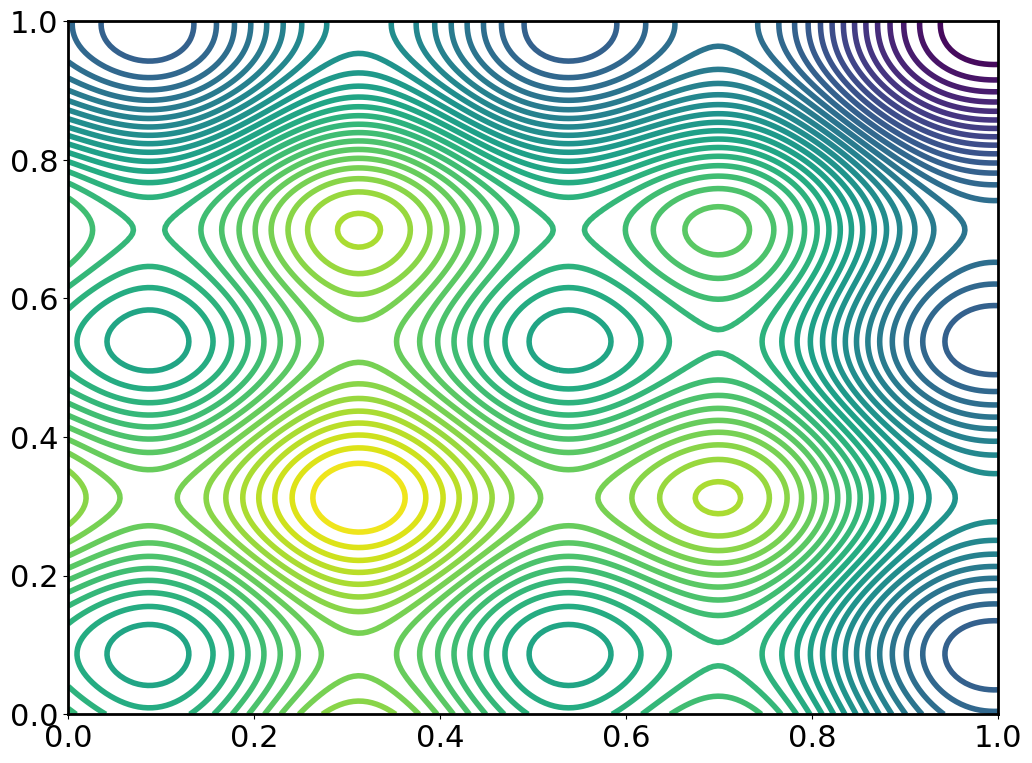

In [3]:
# define design space
n_grid = 200
F_grid = np.zeros([n_grid, n_grid])
X = np.linspace(0, 1, n_grid)
Y = np.linspace(0, 1, n_grid)
Xmesh,Ymesh = np.meshgrid(X,Y)

# test datapoints
X_design = np.stack([Xmesh.ravel(), Ymesh.ravel()]).T
Y_design = generate_data(X_design)

for i, xi in enumerate(X):
    for j, yj in enumerate(Y):
        F_grid[j,i] = f([xi,yj])
        
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(np.min(F_grid), np.max(F_grid), n_grid//5))   
plt.show()

In [4]:
# define number of test points
n_test = 10
n_hidden = 10
noise = .005 # .05 = ~10% of variation in response without noise

# train data points
X_train = np.array([[0., 0.], 
                    [0., 1.],
                    [1., 0.],
                    [1., 1.], 
                    [.5, .5], 
                    [0., .5], 
                    [.5, 0.], 
                    [1., .5],
                    [.5, 1.]])

# X_train = np.random.uniform(size=[3, 2])
# X_train = np.concatenate((X_train_edges, X_train), 0)          
Y_train = generate_data(X_train, noise=noise)

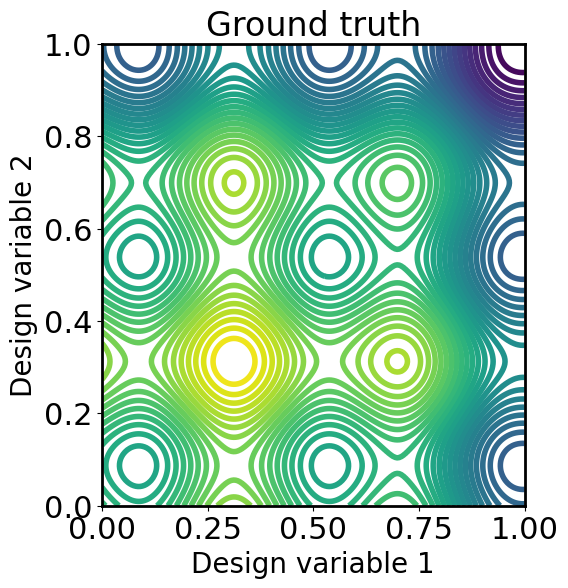

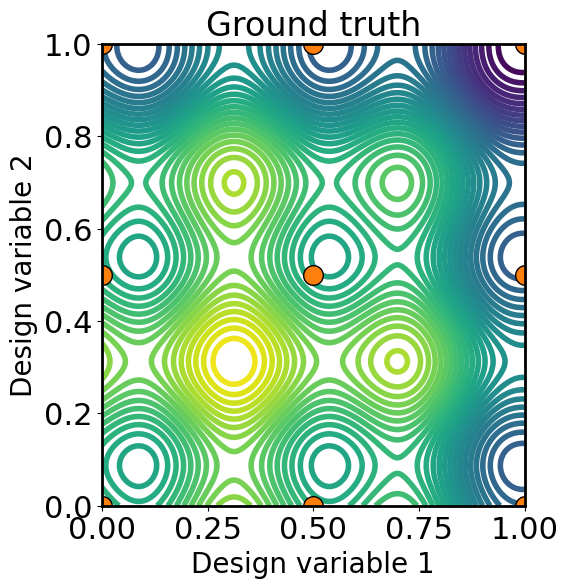

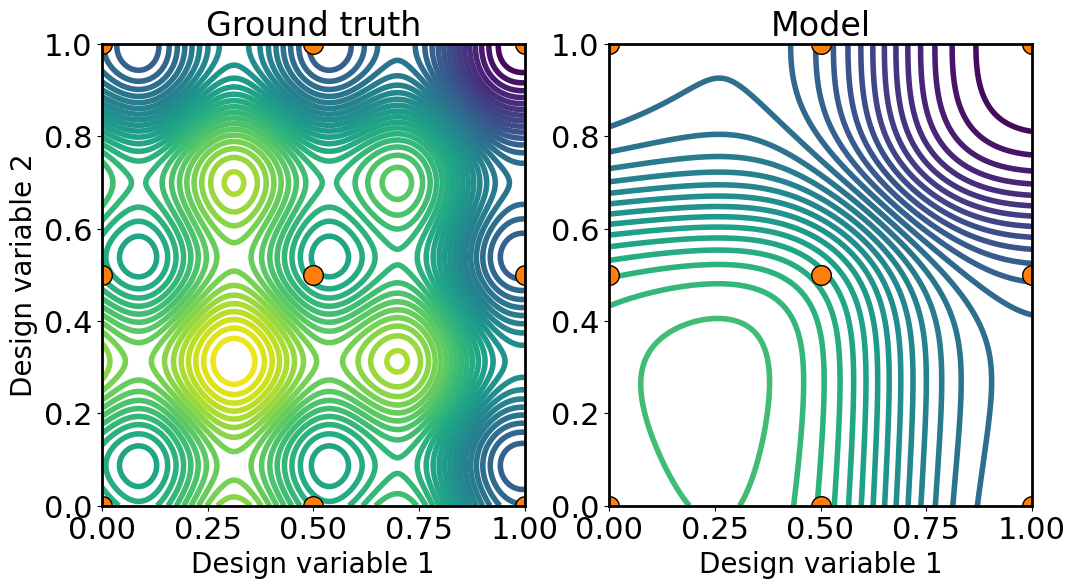

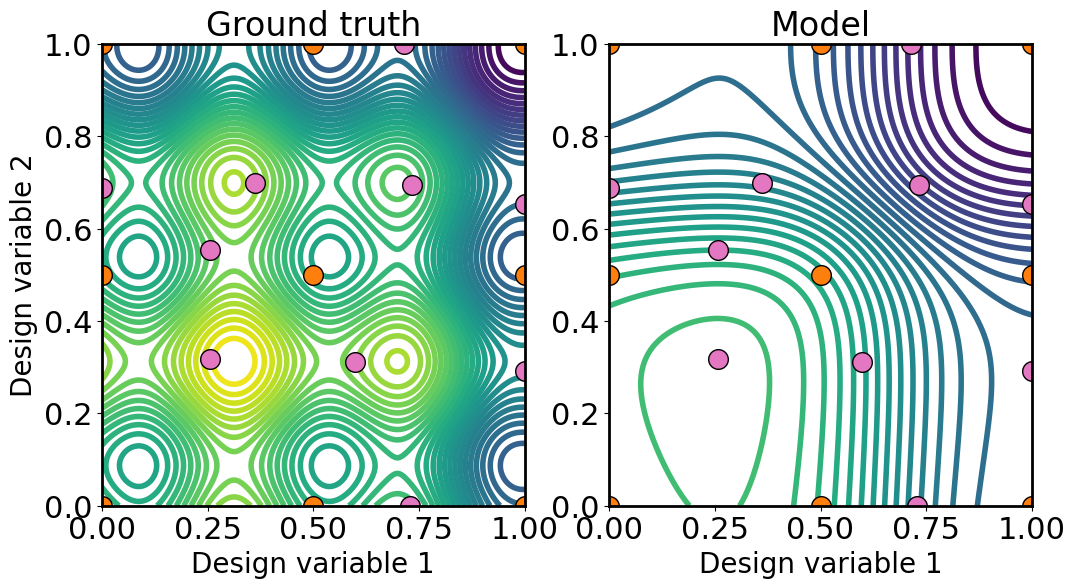

In [5]:
stdv_levels = np.exp(.15*np.linspace(0, 20, n_grid//5)) -1 

# scale data
Xscaler = StandardScaler().fit(X_train)
X_train = Xscaler.transform(X_train)
X_test  = Xscaler.transform(X_design)

Yscaler = StandardScaler().fit(np.vstack(Y_train))
Y_train = Yscaler.transform(np.vstack(Y_train))
Y_test  = Yscaler.transform(np.vstack(Y_design))

n_inputs = X_train.shape[1]
n_outputs = Y_train.shape[1]

# Fit NN
ffnn = FFNN(n_inputs, n_hidden, n_outputs)
t0 = time.time()
ffnn.fit(X_train, Y_train)

# search for new data points
design_inds = ffnn.search_explore(X_test, n_test)
# design_inds = ffnn.search_EI(X_test, objective, n_test, max_reps=10)
# design_inds = ffnn.search_EIG(X_test, objective, n_test, explore=.001)
# design_inds = ffnn.search_Thompson(X_test, objective, n_test)
X_old = Xscaler.inverse_transform(X_train) 
Y_old = Yscaler.inverse_transform(Y_train)
X_new = X_design[design_inds]
Y_new = Y_design[design_inds]

# plot model approximation of objective and uncertainty
Y, Y_stdv = ffnn.predict(X_test)

F_pred = np.reshape(Yscaler.inverse_transform(Y), [n_grid, n_grid])
F_stdv = np.reshape(Yscaler.scale_*Y_stdv, [n_grid, n_grid])
Y_min = np.min(Y_design)
Y_max = np.max(Y_design)

# plot just the system
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
plt.xlabel("Design variable 1")
plt.ylabel("Design variable 2")
plt.title("Ground truth")
plt.savefig(f"figures/NN_explore_1.png", dpi=300)
plt.show()

# plot just the system with data 
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
plt.xlabel("Design variable 1")
plt.ylabel("Design variable 2")
plt.title("Ground truth")
plt.savefig(f"figures/NN_explore_2.png", dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
# plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2, edgecolor='k', c='C6', label='Design')
plt.xlabel("Design variable 1")
plt.ylabel("Design variable 2")
plt.title("Ground truth")

plt.subplot(122)
plt.contour(Xmesh, Ymesh, F_pred, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
plt.xlabel("Design variable 1")
plt.title("Model")
plt.savefig(f"figures/NN_explore_3.png", dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2, edgecolor='k', c='C6', label='Design')
plt.xlabel("Design variable 1")
plt.ylabel("Design variable 2")
plt.title("Ground truth")

plt.subplot(122)
plt.contour(Xmesh, Ymesh, F_pred, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2, edgecolor='k', c='C6', label='Design')
plt.xlabel("Design variable 1")
plt.title("Model")
# plt.tight_layout()
plt.savefig(f"figures/NN_explore_4.png", dpi=300)
plt.show()

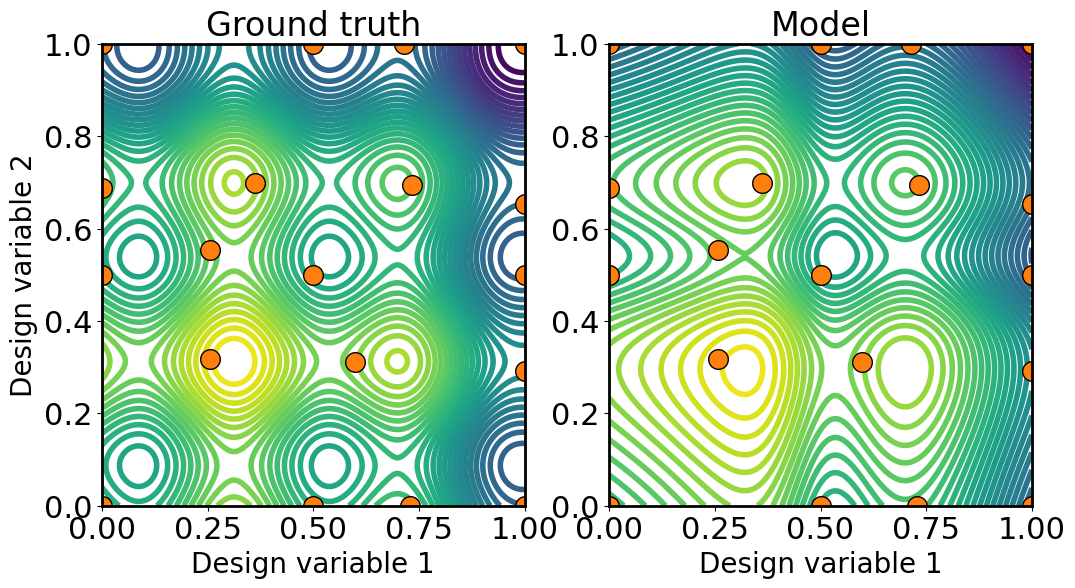

In [6]:
# update training data with new design

# sample data with noise
Y_new = generate_data(X_new, noise=noise)

# update training data with new data 
X_train = np.concatenate((X_old, X_new))
Y_train = np.concatenate((Y_old, Y_new))

# scale data
Xscaler = StandardScaler().fit(X_train)
X_train = Xscaler.transform(X_train)
X_test  = Xscaler.transform(X_design)

Yscaler = StandardScaler().fit(np.vstack(Y_train))
Y_train = Yscaler.transform(np.vstack(Y_train))
Y_test  = Yscaler.transform(np.vstack(Y_design))

n_inputs = X_train.shape[1]
n_outputs = Y_train.shape[1]

# Fit NN
ffnn = FFNN(n_inputs, n_hidden, n_outputs)
t0 = time.time()
ffnn.fit(X_train, Y_train)


X_old = Xscaler.inverse_transform(X_train) 
Y_old = Yscaler.inverse_transform(Y_train)
# X_new = X_design[design_inds]
# Y_new = Y_design[design_inds]

# plot model approximation of objective and uncertainty
Y, Y_stdv = ffnn.predict(X_test)

F_pred = np.reshape(Yscaler.inverse_transform(Y), [n_grid, n_grid])
F_stdv = np.reshape(Yscaler.scale_*Y_stdv, [n_grid, n_grid])
Y_min = np.min(Y_design)
Y_max = np.max(Y_design)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
plt.xlabel("Design variable 1")
plt.ylabel("Design variable 2")
plt.title("Ground truth")

plt.subplot(122)
plt.contour(Xmesh, Ymesh, F_pred, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)
plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1, edgecolor='k', c='C1', label='Train')
plt.xlabel("Design variable 1")
plt.title("Model")
# plt.tight_layout()
plt.savefig(f"figures/NN_explore_5.png", dpi=300)
plt.show()
